In [6]:
# !pip install kaggle
# # your api key
# api_key = {"username":"spacehitchhiker","key":"c698b877d42f3f853d0a599e6263d8a8"}
# from pathlib import Path
# import os
# import json

# # uses pathlib Path
# kaggle_path = Path('/root/.kaggle')
# os.makedirs(kaggle_path, exist_ok=True)

# # opens file and dumps python dict to json object
# with open (kaggle_path/'kaggle.json', 'w') as handl:
#     json.dump(api_key,handl)

# os.chmod(kaggle_path/'kaggle.json', 600)
# !kaggle datasets download -d gpiosenka/butterfly-images40-species

In [7]:
# !unzip -qq butterfly-images40-species.zip -d images40

In [8]:
import torch
import random
import numpy as np

import torch.nn as nn
from torchvision import transforms,datasets
from torchvision.models import resnet18
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

num_classes = 100
model_for_weights = resnet18(weights='DEFAULT')
model_for_weights.fc = nn.Linear(512,num_classes)

In [9]:
data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)
transformation = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.3),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
])

full_dataset = datasets.ImageFolder(
    root='/notebooks/images40/train',
    transform=transformation
)
train_len = int(len(full_dataset)*0.8)
test_len = len(full_dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_len,test_len])

print(len(train_dataset))

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
device

10075


'cuda'

In [10]:
from tqdm import tqdm
optimizer = torch.optim.Adam(model_for_weights.parameters(),lr=.5e-4)
model_for_weights = model_for_weights.to(device)
loss_function = nn.CrossEntropyLoss()

for i in range(n_epochs):
  model_for_weights.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_for_weights(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_for_weights.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_for_weights(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss


  train_len = len(train_loader)
  val_len = len(test_loader)

  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len } val acc:{val_acc / val_len }')

100%|██████████| 79/79 [00:02<00:00, 26.41it/s]


epoch 0: train loss:3.1988823413848877 val loss:1.742053508758545 val acc:0.651279628276825


100%|██████████| 79/79 [00:02<00:00, 26.91it/s]


epoch 1: train loss:1.1860002279281616 val loss:0.9506832361221313 val acc:0.7761420011520386


100%|██████████| 79/79 [00:02<00:00, 29.25it/s]


epoch 2: train loss:0.5926527380943298 val loss:0.7427224516868591 val acc:0.8136351704597473


100%|██████████| 79/79 [00:02<00:00, 29.63it/s]


epoch 3: train loss:0.3157566785812378 val loss:0.6592416167259216 val acc:0.8255022764205933


100%|██████████| 79/79 [00:02<00:00, 28.61it/s]


epoch 4: train loss:0.16815869510173798 val loss:0.6223557591438293 val acc:0.8397255539894104


100%|██████████| 79/79 [00:02<00:00, 28.51it/s]


epoch 5: train loss:0.09566470235586166 val loss:0.5933123826980591 val acc:0.8446270823478699


100%|██████████| 79/79 [00:02<00:00, 29.44it/s]


epoch 6: train loss:0.056936562061309814 val loss:0.5847678780555725 val acc:0.8452635407447815


100%|██████████| 79/79 [00:02<00:00, 27.47it/s]


epoch 7: train loss:0.04191776365041733 val loss:0.5785407423973083 val acc:0.8522289991378784


100%|██████████| 79/79 [00:02<00:00, 28.53it/s]


epoch 8: train loss:0.02728572115302086 val loss:0.581709086894989 val acc:0.8485828042030334


100%|██████████| 79/79 [00:02<00:00, 29.64it/s]

epoch 9: train loss:0.0194966159760952 val loss:0.5737411975860596 val acc:0.8510422706604004


In [11]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

from tqdm import tqdm

In [12]:
def get_loaders(batch_size=32, augments=[True, False], shuffles=[True, False]):
    full_dataset = datasets.ImageFolder(
        root='/notebooks/images40/train',
        transform=transformation
    )
    train_len = int(len(full_dataset)*0.8)
    test_len = len(full_dataset) - train_len
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_len,test_len])

    return train_dataset, test_dataset

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
train_dataset,test_dataset = get_loaders()
batch_size = 32

In [15]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=False,
    pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size, shuffle=True,
    pin_memory=True, num_workers=2)

In [16]:
model_for_weights = model_for_weights.to(device)

In [17]:
# num_classes = 100

class_count = dict(zip(range(num_classes),[0]*(num_classes)))
for _,y in tqdm(test_loader):
    for label in y:
        class_count[label.item()] += 1

# class_count

class_acc = dict(zip(range((num_classes)),[0]*(num_classes)))

for x,y in tqdm(test_loader):
    x,y = x.to(device), y.to(device)
    logits = model_for_weights(x)
    preds = logits.max(1)[1]
    for (predicted,target) in zip(preds,y):
      if predicted == target:
        class_acc[target.item()] += 1

for key in class_acc.keys():
  class_acc[key] /= class_count[key]

sorted_by_acc = sorted(class_acc.items(),key=lambda x:x[1])
print(sorted_by_acc)

100%|██████████| 79/79 [00:01<00:00, 50.62it/s]

[(75, 0.7727272727272727), (36, 0.8), (37, 0.8823529411764706), (93, 0.8823529411764706), (9, 0.9), (98, 0.9), (57, 0.9090909090909091), (62, 0.9090909090909091), (56, 0.9130434782608695), (29, 0.9166666666666666), (33, 0.92), (77, 0.92), (40, 0.9230769230769231), (1, 0.9285714285714286), (81, 0.9310344827586207), (52, 0.9333333333333333), (2, 0.9411764705882353), (43, 0.9411764705882353), (79, 0.9411764705882353), (24, 0.95), (4, 0.9523809523809523), (97, 0.9523809523809523), (28, 0.9545454545454546), (45, 0.9545454545454546), (49, 0.9545454545454546), (50, 0.9545454545454546), (61, 0.9545454545454546), (69, 0.9565217391304348), (73, 0.9565217391304348), (92, 0.9565217391304348), (88, 0.9583333333333334), (42, 0.96), (53, 0.96), (54, 0.96), (11, 0.9615384615384616), (80, 0.9615384615384616), (30, 0.9629629629629629), (68, 0.9629629629629629), (60, 0.9642857142857143), (89, 0.9642857142857143), (63, 0.9655172413793104), (18, 0.9666666666666667), (67, 0.9666666666666667), (71, 0.9677419

In [18]:
acc_on_sample_class = []
with torch.no_grad():
  for x,y in  tqdm(train_loader):
      for label in y:
            acc_on_sample_class.append(class_acc[label.item()])

# np.unique(acc_on_sample_class,return_counts=True)
acc_on_sample_class = np.array(acc_on_sample_class)

100%|██████████| 315/315 [00:06<00:00, 52.18it/s]


Make dict to save loss history on test_data for different curriclum modes

In [19]:
losses_train_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}
losses_val_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}
acc_val_history = {'random':[],'hard first':[],'easy first':[],'mixed':[]}

1)Random

In [20]:
from torchvision.models import resnet18

model = resnet18(weights='DEFAULT')
model.fc = nn.Linear(512,num_classes)

In [21]:
optimizer = torch.optim.Adam(model.parameters(),lr=.5e-4)
loss_function = nn.CrossEntropyLoss()
model.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [22]:
for x,y in train_loader:
  print(x.shape,y.shape)
  break

x = x.to(device)
output = model(x)
print(output.shape)

y = y.to(device)
loss = loss_function(output,y)
loss

torch.Size([32, 3, 64, 64]) torch.Size([32])
torch.Size([32, 100])


tensor(5.0515, device='cuda:0', grad_fn=<NllLossBackward0>)

In [23]:
# n_epochs = N_EPOCHS

for i in range(n_epochs):
  model.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss


  train_len = len(train_loader)
  val_len = len(test_loader)

  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len } val acc:{val_acc / val_len }')

  losses_train_history['random'].append(train_loss / train_len)
  losses_val_history['random'].append(val_loss / val_len)
  acc_val_history['random'].append(val_acc / val_len)

100%|██████████| 79/79 [00:01<00:00, 44.48it/s]


epoch 0: train loss:3.1751177310943604 val loss:1.7151706218719482 val acc:0.6586577892303467


100%|██████████| 79/79 [00:01<00:00, 44.37it/s]


epoch 1: train loss:1.1093416213989258 val loss:0.990593671798706 val acc:0.7908297181129456


100%|██████████| 79/79 [00:01<00:00, 48.66it/s]


epoch 2: train loss:0.42140474915504456 val loss:0.8246850371360779 val acc:0.8094386458396912


100%|██████████| 79/79 [00:01<00:00, 43.40it/s]


epoch 3: train loss:0.15387913584709167 val loss:0.7609840035438538 val acc:0.816782534122467


100%|██████████| 79/79 [00:01<00:00, 43.99it/s]


epoch 4: train loss:0.06377318501472473 val loss:0.7310757637023926 val acc:0.818295955657959


100%|██████████| 79/79 [00:01<00:00, 50.05it/s]


epoch 5: train loss:0.03425438702106476 val loss:0.7142542600631714 val acc:0.8212197422981262


100%|██████████| 79/79 [00:01<00:00, 49.33it/s]


epoch 6: train loss:0.02177557535469532 val loss:0.7023827433586121 val acc:0.8228020071983337


100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


epoch 7: train loss:0.015066392719745636 val loss:0.6938941478729248 val acc:0.8253302574157715


100%|██████████| 79/79 [00:01<00:00, 49.27it/s]


epoch 8: train loss:0.010981000028550625 val loss:0.6898192763328552 val acc:0.825725793838501


100%|██████████| 79/79 [00:01<00:00, 45.86it/s]

epoch 9: train loss:0.00827779434621334 val loss:0.6840303540229797 val acc:0.8301458358764648


In [24]:
def get_loaders_weighted(train_dataset,test_dataset,weights,data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[False, False]):
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement=False)
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, sampler = sampler,
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

2)hard first

In [25]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,num_classes)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=.5e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [26]:

for i in range(n_epochs):
  if i < n_epochs//2:
    weights =  (1+acc_on_sample_class) ** (-2)
  else:
    weigths = np.array([1]*len(acc_on_sample_class))
  train_loader,test_loader = get_loaders_weighted(train_dataset,test_dataset,weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_transfer(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss


  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }  val acc:{val_acc / val_len }')

  losses_train_history['hard first'].append(train_loss / train_len)
  losses_val_history['hard first'].append(val_loss / val_len)
  acc_val_history['hard first'].append(val_acc / val_len)

100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


epoch 0: train loss:3.2252566814422607 val loss:1.7314281463623047  val acc:0.6521739363670349


100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


epoch 1: train loss:1.20842707157135 val loss:0.9298898577690125  val acc:0.7951981425285339


100%|██████████| 79/79 [00:01<00:00, 43.42it/s]


epoch 2: train loss:0.5868143439292908 val loss:0.7181520462036133  val acc:0.8284947872161865


100%|██████████| 79/79 [00:01<00:00, 45.77it/s]


epoch 3: train loss:0.315545916557312 val loss:0.6243151426315308  val acc:0.8404478430747986


100%|██████████| 79/79 [00:01<00:00, 48.74it/s]


epoch 4: train loss:0.17158979177474976 val loss:0.5825029611587524  val acc:0.8518334031105042


100%|██████████| 79/79 [00:01<00:00, 47.60it/s]


epoch 5: train loss:0.09290450811386108 val loss:0.5743951797485352  val acc:0.8500103950500488


100%|██████████| 79/79 [00:01<00:00, 49.99it/s]


epoch 6: train loss:0.05743588134646416 val loss:0.5654063820838928  val acc:0.8528653383255005


100%|██████████| 79/79 [00:01<00:00, 50.69it/s]


epoch 7: train loss:0.038466472178697586 val loss:0.5683885812759399  val acc:0.8577669858932495


100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


epoch 8: train loss:0.027635084465146065 val loss:0.563559353351593  val acc:0.856975793838501


100%|██████████| 79/79 [00:01<00:00, 49.76it/s]

epoch 9: train loss:0.02121761627495289 val loss:0.5681321024894714  val acc:0.8585581183433533


3)easy first

In [27]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,num_classes)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=.5e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [28]:
for i in range(n_epochs):
  if i < n_epochs//2:
    weights =  (1+acc_on_sample_class) ** (2)
  else:
    weigths = np.array([1]*len(acc_on_sample_class))
  train_loader,test_loader = get_loaders_weighted(train_dataset,test_dataset,weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_transfer(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss


  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }  val acc:{val_acc / val_len }')

  losses_train_history['easy first'].append(train_loss / train_len)
  losses_val_history['easy first'].append(val_loss / val_len)
  acc_val_history['easy first'].append(val_acc / val_len)

100%|██████████| 79/79 [00:01<00:00, 42.26it/s]


epoch 0: train loss:3.2369229793548584 val loss:1.7909111976623535  val acc:0.6232973337173462


100%|██████████| 79/79 [00:01<00:00, 47.42it/s]


epoch 1: train loss:1.2306267023086548 val loss:0.930098831653595  val acc:0.7895053625106812


100%|██████████| 79/79 [00:01<00:00, 49.22it/s]


epoch 2: train loss:0.596340000629425 val loss:0.7106826901435852  val acc:0.8246250748634338


100%|██████████| 79/79 [00:01<00:00, 48.07it/s]


epoch 3: train loss:0.3144489824771881 val loss:0.6244058012962341  val acc:0.8395019769668579


100%|██████████| 79/79 [00:01<00:00, 50.63it/s]


epoch 4: train loss:0.1687803417444229 val loss:0.5929400324821472  val acc:0.8471725583076477


100%|██████████| 79/79 [00:01<00:00, 47.81it/s]


epoch 5: train loss:0.09622643887996674 val loss:0.5670260787010193  val acc:0.8584032654762268


100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


epoch 6: train loss:0.05526585876941681 val loss:0.5652989149093628  val acc:0.8560298681259155


100%|██████████| 79/79 [00:01<00:00, 47.25it/s]


epoch 7: train loss:0.03833692520856857 val loss:0.5569219589233398  val acc:0.8590396046638489


100%|██████████| 79/79 [00:01<00:00, 47.84it/s]


epoch 8: train loss:0.027560967952013016 val loss:0.5497032403945923  val acc:0.8651279807090759


100%|██████████| 79/79 [00:01<00:00, 45.05it/s]

epoch 9: train loss:0.021267985925078392 val loss:0.5611828565597534  val acc:0.857612133026123


In [29]:
def tensor_list_to_list(list_of_tensors):
  return [t.item() for t in list_of_tensors]

4)mixed

In [30]:
model_transfer = resnet18(weights='DEFAULT')
model_transfer.fc = nn.Linear(512,num_classes)
optimizer = torch.optim.Adam(model_transfer.parameters(),lr=.5e-4)
loss_function = nn.CrossEntropyLoss()
model_transfer.to(device)
print(f'Model is on device: {device}')

Model is on device: cuda


In [31]:

for i in range(n_epochs):
  weights = 1. / ( acc_on_sample_class + 1.0)**((n_epochs//2 - i) / 10)
  train_loader,test_loader = get_loaders_weighted(train_dataset,test_dataset,weights)
  model_transfer.train()
  train_loss = 0
  for x,y in tqdm(train_loader):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    preds = model_transfer(x)
    loss = loss_function(preds,y)
    train_loss += loss
    loss.backward()
    optimizer.step()

  model_transfer.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x,y in  tqdm(test_loader):
      x, y = x.to(device), y.to(device)
      logits = model_transfer(x)
      preds = logits.max(dim=1)[1]
      val_acc += torch.mean((preds == y).float())
      loss = loss_function(logits,y)
      val_loss += loss


  train_len = len(train_loader)
  val_len = len(test_loader)
  print(f'epoch {i}: train loss:{train_loss / train_len } val loss:{val_loss / val_len }  val acc:{val_acc / val_len }')

  losses_train_history['mixed'].append(train_loss / train_len)
  losses_val_history['mixed'].append(val_loss / val_len)
  acc_val_history['mixed'].append(val_acc / val_len)

100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


epoch 0: train loss:3.1691184043884277 val loss:1.689974308013916  val acc:0.6604809165000916


100%|██████████| 79/79 [00:01<00:00, 50.80it/s]


epoch 1: train loss:1.1778614521026611 val loss:0.9300628304481506  val acc:0.7842770218849182


100%|██████████| 79/79 [00:01<00:00, 47.66it/s]


epoch 2: train loss:0.5744212865829468 val loss:0.6986722946166992  val acc:0.8313497304916382


100%|██████████| 79/79 [00:01<00:00, 48.99it/s]


epoch 3: train loss:0.31487154960632324 val loss:0.611339271068573  val acc:0.8466910123825073


100%|██████████| 79/79 [00:01<00:00, 48.12it/s]


epoch 4: train loss:0.1657567173242569 val loss:0.5790117383003235  val acc:0.8571306467056274


100%|██████████| 79/79 [00:01<00:00, 53.17it/s]


epoch 5: train loss:0.0964846983551979 val loss:0.565852701663971  val acc:0.8602951765060425


100%|██████████| 79/79 [00:01<00:00, 52.68it/s]


epoch 6: train loss:0.05746462941169739 val loss:0.5453941226005554  val acc:0.8646464347839355


100%|██████████| 79/79 [00:01<00:00, 50.03it/s]


epoch 7: train loss:0.03847644850611687 val loss:0.5539934039115906  val acc:0.8634597659111023


100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


epoch 8: train loss:0.026982152834534645 val loss:0.5441076159477234  val acc:0.86638343334198


100%|██████████| 79/79 [00:01<00:00, 53.68it/s]

epoch 9: train loss:0.020068101584911346 val loss:0.5397237539291382  val acc:0.8655923008918762


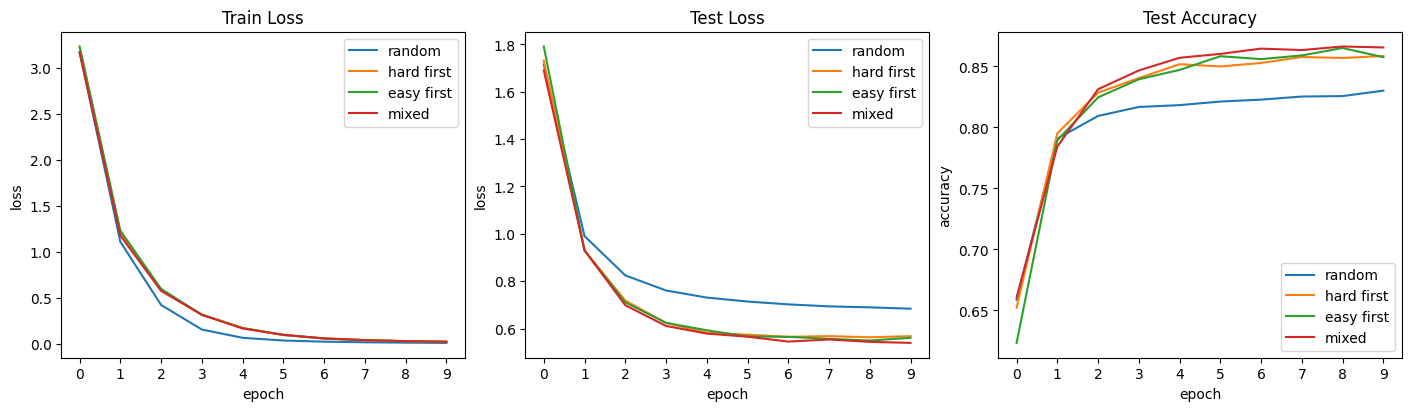

In [35]:
def tensor_to_list(t):
    return [el.item() for el in t][:12]

fig,axes = plt.subplots(1,3,figsize=(14,4),constrained_layout=True)

for mode in acc_val_history.keys():
    axes[2].plot(range(n_epochs), tensor_to_list(acc_val_history[mode]),label=mode)
    axes[2].legend()
    axes[2].set_xticks(range(n_epochs))

axes[2].set_title('Test Accuracy')


for mode in losses_val_history.keys():
    axes[1].plot(range(n_epochs), tensor_to_list(losses_val_history[mode]),label=mode)

axes[1].set_title('Test Loss')
axes[1].legend()
axes[1].set_xticks(range(n_epochs))

for index,ax in enumerate(axes):
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss' if index < 2 else 'accuracy')

for mode in losses_train_history.keys():
    axes[0].plot(range(n_epochs), tensor_to_list(losses_train_history[mode]),label=mode)

axes[0].set_title('Train Loss')
axes[0].legend()
axes[0].set_xticks(range(n_epochs))

plt.savefig('butterfly_tr_cl_metrics.png')


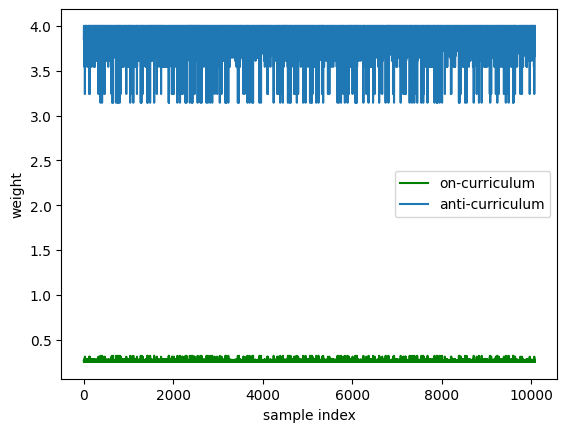

In [34]:
num_samples = len(acc_on_sample_class)
on_curr_weights = 1. / (acc_on_sample_class + 1.0)**(2)
anti_curr_weights = 1. / (acc_on_sample_class + 1.0)**(-2)
plt.plot(range(num_samples),on_curr_weights,label='on-curriculum',c='green')
plt.plot(range(num_samples),anti_curr_weights,label='anti-curriculum')
plt.xlabel('sample index')
plt.ylabel('weight')
plt.legend()
plt.savefig('sample weights.png')

In [ ]:
model.eval()
true_test_dataset = datasets.ImageFolder(
    root='/content/test',
    transform=transformation
)

true_test_loader = torch.utils.data.DataLoader(
    dataset=true_test_dataset,
    batch_size=2, shuffle=True,
    pin_memory=True, num_workers=2)

acc = 0

for x,y in test_loader:
    x,y  = x.to(device),y.to(device)
    preds = model(x).max(1)[1]
    acc += torch.mean((preds == y).float())

acc / len(test_loader)